In [5]:
import rasterio as rio
import geopandas as gpd
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.merge import merge
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import os
from shapely.geometry import box
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
from osgeo import gdal
from shapely.geometry import box

In [145]:
#Prep NFI Map
nfi = gpd.read_file('https://opendata.arcgis.com/datasets/d3d7bfba1cba4a3b83a948f33c5777c0_0.geojson')
nfi = nfi[nfi['CATEGORY']=='Woodland']
nfi = nfi[nfi['IFT_IOA'].isin(['Broadleaved','Conifer','Mixed mainly broadleaved','Mixed mainly conifer'])]
nfi = nfi.to_crs('EPSG:27700')
with rio.open(img_file) as r:
    minx, miny, maxx, maxy= r.bounds
img_extent = gpd.GeoDataFrame(geometry=[box(minx, miny, maxx, maxy)], crs='EPSG:27700')
use_nfi = gpd.overlay(nfi, img_extent, how='intersection')
use_nfi.to_file('../../data/nfi_woodland_scot1.shp', index=False)

In [4]:
grid_gdf = gpd.read_file('../../data/chip_grid.shp')

In [5]:
forest = gpd.read_file('../../data/nfi_woodland_scot1.shp')

In [6]:
clearfell = gpd.read_file('../../data/Scot1_felledSCDBonly.shp')

In [2]:
img_file = '../../data/scot1MedianJuly2018.tif'

In [186]:
intersection = gpd.overlay(grid_gdf, forest, how='intersection')
intersection = gpd.overlay(intersection, clearfell, how = 'intersection')

In [187]:
grid_use = grid_gdf[grid_gdf['location'].isin(intersection['location'])]

In [188]:
grid_use=grid_use[['location','geometry']]
grid_list = grid_use['location'].to_list()

In [189]:
for grid in grid_list:
    row = grid_use[grid_use['location']==grid]
    forest_polys = gpd.overlay(row, forest, how='intersection')
    with rio.open(img_file) as r:
        img_arr, trans = mask(r, row['geometry'], crop=True)
        out_meta = r.meta
    forest_img = rasterize(forest_polys['geometry'], transform=trans, out_shape=(img_arr.shape[1], img_arr.shape[2]))
    forest_img = np.expand_dims(forest_img, axis=0)
    img_arr = np.vstack([img_arr, forest_img])
    out_meta.update(count=img_arr.shape[0], width=img_arr.shape[1], height=img_arr.shape[2], transform=trans)
    if not os.path.exists('../../data/chips'):
        os.makedirs('../../data/chips')
    with rio.open(f'../../data/chips/s1_chip_{row.iloc[0,0]}.tif', 'w', **out_meta) as f:
            f.write(img_arr)

In [83]:
def scale_s1_bands(img_arr):
    scale_dict = {0:(-20,-5),1:(-25,-10),2:(0,15),3:(-20,-5),4:(-25,-10),5:(0,15)}
    for i in range(6):
        min = scale_dict[i][0]
        max = scale_dict[i][1]
        img_arr[i][img_arr[i]<min]=min
        img_arr[i][img_arr[i]>max]=max
        img_arr[i]=img_arr[i]/max
    return img_arr

In [5]:
tifs= [f"../../data/chips/{f}" for f in os.listdir('../../data/chips') if f.endswith('.tif')]

def read_img(img):
    with rio.open(img) as f:
        return f.read()

img_features = [read_img(f) for f in tifs]

img_features = [scale_s1_bands(f) for f in img_features]

img_features = [reshape_as_image(i) for i in img_features]

all_imgs = np.stack(img_features, axis=0)

np.savez_compressed('../../data/all_img_chips', all_imgs=all_imgs)

In [7]:
all_imgs = shuffle(all_imgs)
train, valid = train_test_split(all_imgs)

#Convert the numpy arrays to tensorflow for each function to put into batches
train_dataset = tf.data.Dataset.from_tensor_slices((train[:,:,:,:6], train[:,:,:,6]))
validation_dataset = tf.data.Dataset.from_tensor_slices((valid[:,:,:,:6], valid[:,:,:,6]))

train_dataset = train_dataset.batch(16)
validation_dataset = validation_dataset.batch(16)

In [12]:
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import metrics
from tensorflow.python.keras import optimizers

def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model():
	inputs = layers.Input(shape=[256,256,6]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256
	outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])

	model.compile(
		optimizer=optimizers.get('adam'), 
		loss=losses.get('binary_crossentropy'),
		metrics=[metrics.get(metric) for metric in ['Precision','Recall']])

	return model

In [13]:
model = get_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 6) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 1760        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
#Fit the model
history = model.fit(train_dataset, epochs=10, batch_size=16, validation_data = validation_dataset)

Epoch 1/10
28/28 [==============================] - 224s 8s/step - loss: 0.4396 - precision: 0.6756 - recall: 0.7111 - val_loss: 0.7838 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
28/28 [==============================] - 221s 8s/step - loss: 0.3136 - precision: 0.8208 - recall: 0.7452 - val_loss: 0.7702 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
28/28 [==============================] - 215s 8s/step - loss: 0.2831 - precision: 0.8485 - recall: 0.7590 - val_loss: 0.7763 - val_precision: 0.5647 - val_recall: 9.0867e-04
Epoch 4/10
28/28 [==============================] - 220s 8s/step - loss: 0.2699 - precision: 0.8574 - recall: 0.7711 - val_loss: 0.8909 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
28/28 [==============================] - 218s 8s/step - loss: 0.2561 - precision: 0.8657 - recall: 0.7791 - val_loss: 0.7702 - val_precision: 0.8333 - val_recall: 1.9143e-05
Epoch 6/10
28/28 [==============================] - 223s 8s/ste

In [21]:
results = model.predict(validation_dataset)

In [31]:
def classify_img(pred_arr, threshold=0.5):
    return np.where(pred_arr>=0.5,1,0)

Text(0.5, 1.0, 'predicted')

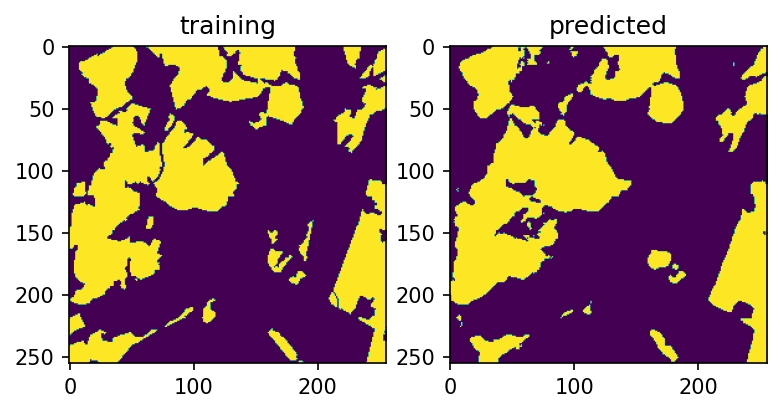

In [48]:
random_idx = random.randint(0, valid.shape[0])

plt.rcParams['figure.dpi'] = 150
f, axarr = plt.subplots(1,2)
axarr[0].imshow(valid[random_idx,:,:,6])
axarr[0].set_title('training')
axarr[1].imshow(classify_img(results[random_idx]))
axarr[1].set_title('predicted')

In [ ]:
def get_pixels_clipped(poly, img):
    with rio.open(img) as r:
        return mask(r, poly, crop=True)

In [ ]:
def classify_chips(cnn_model, grid_gdf, source_img):
    if not os.path.exists('../../data/chip_res'):
        os.mkdir('../../data/chip_res')
    grids = grid_gdf['location'].to_list()
    for i, g in enumerate(grids):
        row = grid_gdf[grid_gdf['location']==g]
        with rio.open(source_img) as r:
            img_arr, trans = mask(r, row['geometry'], crop=True)
            out_meta = r.meta
        img_arr = scale_s1_bands(img_arr)
        img_arr = reshape_as_image(img_arr)
        img_arr = np.expand_dims(img_arr, axis=0)
        pred_img = cnn_model.predict(img_arr)
        pred_img = classify_img(pred_img[0])
        pred_img = pred_img.astype('uint8')
        pred_img = reshape_as_raster(pred_img)
        out_meta.update(count=1, width=pred_img.shape[1], height=pred_img.shape[2], transform=trans, dtype="uint8")
        with rio.open(f'../../data/chip_res/class_chip_{row.iloc[0,0]}.tif', 'w', **out_meta) as f:
            f.write(pred_img)
        if i % 100 ==0:
                print(f"processed {i} of {len(grids)}")




In [14]:
def mosaic_chip_max(res_chip_dir, source_img):
    res_chips = [f"{res_chip_dir}/{file}" for file in os.listdir(res_chip_dir) if file.endswith(".tif") and "chip" in file]
    with rio.open(source_img) as f:
        out_meta = f.meta
        bounds = f.bounds
    class_img, trans = merge(res_chips, method="max", precision=50, bounds=bounds)
    class_img = class_img.astype("uint8")
    out_meta.update(count=1, dtype="uint8")
    with rio.open(f"{res_chip_dir}/classified_result.tif", "w", **out_meta) as f:
        f.write(class_img[0], indexes=1)
    
    

In [88]:
classify_chips(model, grid_gdf, img_file)

processed 0 of 7830
processed 100 of 7830
processed 200 of 7830
processed 300 of 7830
processed 400 of 7830
processed 500 of 7830
processed 600 of 7830
processed 700 of 7830
processed 800 of 7830
processed 900 of 7830
processed 1000 of 7830
processed 1100 of 7830
processed 1200 of 7830
processed 1300 of 7830
processed 1400 of 7830
processed 1500 of 7830
processed 1600 of 7830
processed 1700 of 7830
processed 1800 of 7830
processed 1900 of 7830
processed 2000 of 7830
processed 2100 of 7830
processed 2200 of 7830
processed 2300 of 7830
processed 2400 of 7830
processed 2500 of 7830
processed 2600 of 7830
processed 2700 of 7830
processed 2800 of 7830
processed 2900 of 7830
processed 3000 of 7830
processed 3100 of 7830
processed 3200 of 7830
processed 3300 of 7830
processed 3400 of 7830
processed 3500 of 7830
processed 3600 of 7830
processed 3700 of 7830
processed 3800 of 7830
processed 3900 of 7830
processed 4000 of 7830
processed 4100 of 7830
processed 4200 of 7830
processed 4300 of 7830


In [15]:
mosaic_chip_max("../../data/chip_res/", img_file)

In [11]:
res_chips = [f"../../data/chip_res/{file}" for file in os.listdir('../../data/chip_res') if file.endswith(".tif") and "chip" in file]

In [12]:
img_arr, trans = rasterio.merge.merge(res_chips, method="max")

In [13]:
trans

Affine(10.0, 0.0, 284860.0,
       0.0, -10.0, 671400.0)

In [33]:
os.chdir("../../data/chip_res/")
tifs = [file for file in os.listdir() if file.endswith(".tif") and "chip" in file]
with open("chip_files.txt", "w") as f:
    for t in tifs:
        f.write(t+"\n")
! gdalbuildvrt all_chips.vrt -input_file_list chip_files.txt
add_pixel_max("all_chips.vrt")
! gdal_translate --config GDAL_VRT_ENABLE_PYTHON YES all_chips.vrt classified_result.tif

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 11648, 11264
0ERROR 1: <class 'AttributeError'>, module 'gdal_vrt_module_0x7fe447c04ee0' has no attribute 'max'


In [20]:
add_pixel_max("all_chips.vrt")

In [34]:
! gdal_translate -config GDAL_VRT_ENABLE_PYTHON YES all_chips.vrt classified_result.tif

Input file size is 11648, 11264
0ERROR 1: <class 'AttributeError'>, module 'gdal_vrt_module_0x7fe1dac07c00' has no attribute 'max'
